# Download e caricamento librerie necessarie

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Per sapere che GPU è assegnata 

from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 12540303478546818344, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16293794921564630471
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 10542055367863987888
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7304675328
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 4847966912999057844
 physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"]

In [ ]:
!pip install kmeanstf

In [ ]:
%%capture
!pip install contractions

In [ ]:
import pandas as pd
from tqdm import tqdm, tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import nltk
from datetime import datetime, timedelta
import regex as re
from nltk.stem import PorterStemmer 
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import json
import functools
import itertools
import contractions
import ast

import sklearn
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sn

import spacy
from spacy import displacy
from collections import Counter
import en_core_web_sm


from kmeanstf import KMeansTF
from scipy.spatial.distance import cdist


nlp = en_core_web_sm.load()

# per usare progress_apply
tqdm_notebook().pandas()

nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download("punkt")

pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:39: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:46: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# Load Dataset

Gli *url* e *tag html* sono già stati rimossi

In [ ]:
data = pd.read_csv('/content/drive/My Drive/Consegna/df_classification.csv')

In [ ]:
data = data[data["target"]=="CD"]
data = data[["asin", "reviewText", "summary", "target"]]

# Preprocessing

In [ ]:
def create_sentence(x):
  res = ' '.join(x)
  return res

## NER

In [ ]:
def trova_persona(testo,label):
  label_ent = []
  doc = nlp(testo)
  for x in doc.ents:
    if x.label_==label:
      #print(x.text)
      label_ent.append(x.text)

  return list(dict.fromkeys(label_ent))

In [ ]:
data['NER_PERSON'] = data['reviewText'].progress_apply(lambda x: trova_persona(x,'PERSON'))

In [ ]:
data['WORK_OF_ART'] = data['reviewText'].progress_apply(lambda x: trova_persona(x,'WORK_OF_ART'))

In [ ]:
## Per filtrare nomi o titoli con non più di n parole


person = data['NER_PERSON']
person = person.tolist()
person = list(itertools.chain(*person))

dict_person = dict(Counter(person))
df_person = pd.DataFrame(dict_person.items(),columns=['name','count'])

df_person['n_word'] = df_person['name'].apply(lambda x: len(x.split()))



art = data['WORK_OF_ART']
art = art.tolist()
art = list(itertools.chain(*art))

dict_art = dict(Counter(art))
df_art = pd.DataFrame(dict_art.items(),columns=['name','count'])

df_art['n_word'] = df_art['name'].apply(lambda x: len(x.split()))

In [ ]:
ner_person_valid = list(df_person[df_person["n_word"]<=3]["name"])
ner_art_valid = list(df_art[df_art["n_word"]<=3]["name"])

In [ ]:
data['NER_PERSON'] = data['NER_PERSON'].progress_apply(lambda x: list(set(x) & set(ner_person_valid)))
data['WORK_OF_ART'] = data['WORK_OF_ART'].progress_apply(lambda x: list(set(x) & set(ner_art_valid)))

In [ ]:
def funz(frase):
    text_no_namedentities = ""
    for token in nlp(frase):
        if not ((token.ent_type_ == "PERSON") | (token.ent_type_ == "WORK_OF_ART")):
            text_no_namedentities += token.text
            if token.whitespace_:
                text_no_namedentities += " "
    return(text_no_namedentities)

In [ ]:
data.head(1)

,asin,reviewText,summary,target,NER_PERSON,WORK_OF_ART
0,0001393774,"Keith Green had a passionate love for Jesus. This is evident in his life as well as in his music. He didn't preach Jesus at concerts sponsored by beer companies. He didn't get divorced and remarried. He didn't live a life of luxury off of his royalties while billions starved. He was the real deal. He was a real Christian.\n\nMuch of his music consists of love songs to God, and listening to this music Keith's love for Jesus encourages me. Hearing the tender serenades of a true lover of Jesus fans the flame of the listener's own passion. It's contagious.",Passionate Faith Is Contagious,CD,"[Keith Green, Keith, Jesus]",[]


In [ ]:
data["text_no_ner"] = data["reviewText"].progress_apply(lambda x: funz(x))

In [ ]:
data.head(1)

,asin,reviewText,summary,target,NER_PERSON,WORK_OF_ART,text_no_ner
0,0001393774,"Keith Green had a passionate love for Jesus. This is evident in his life as well as in his music. He didn't preach Jesus at concerts sponsored by beer companies. He didn't get divorced and remarried. He didn't live a life of luxury off of his royalties while billions starved. He was the real deal. He was a real Christian.\n\nMuch of his music consists of love songs to God, and listening to this music Keith's love for Jesus encourages me. Hearing the tender serenades of a true lover of Jesus fans the flame of the listener's own passion. It's contagious.",Passionate Faith Is Contagious,CD,"[Keith Green, Keith, Jesus]",[],"had a passionate love for . This is evident in his life as well as in his music. He didn't preach at concerts sponsored by beer companies. He didn't get divorced and remarried. He didn't live a life of luxury off of his royalties while billions starved. He was the real deal. He was a real Christian.\n\nMuch of his music consists of love songs to God, and listening to this music 's love for encourages me. Hearing the tender serenades of a true lover of fans the flame of the listener's own passion. It's contagious."


In [ ]:
#data.to_csv("/content/drive/My Drive/Text Mining Progetto/Clustering/data_ner.csv", index=False)

## Tokenization

In [ ]:
def tokenize_only(text):
  text = text.replace('/', " ")
  text = text.replace('=', " ")
  text = text.replace('_', " ")
  text = text.replace('-', " ")
  text = text.replace('.', " ")
  text = text.replace('+', " ")
  text = text.replace('\\', " ")
  # tokenization and lower case
  tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
  filtered_tokens = []
  for token in tokens:
    if re.search('[a-zA-Z]', token):
      token = re.sub(r'[^\w]', '', token) # rimozione simboli
      token = re.sub(r'[0-9]+', '', token) # rimozione numeri
      filtered_tokens.append(token)
  return filtered_tokens

In [ ]:
data['text_token'] = data['text_no_ner'].progress_apply(lambda x: tokenize_only(x))

## Normalization

In [ ]:
def manage_contractions_slang(el):
  ris=contractions.fix(el,slang=True)
  return ris

In [ ]:
data['text_token'] = data["text_token"].progress_apply(lambda x: list(map(manage_contractions_slang, x)))

## Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

In [ ]:
def get_dict_lemma(ris):
  dict_lemma = dict()
  list_tag=['N','J','R','V']

  for el in ris:
    if el[0]!=el[1]:
      tag=el[1][0]
      if tag in list_tag:
        if tag=='J':
          tag='A'
        if el[0] not in dict_lemma.keys():
          dict_lemma[el[0]] = [tag.lower()]
          word=el[0]
        else:
          dict_lemma[el[0]].append(tag.lower())
  return dict_lemma


def get_tag_lemma(text):
  ris = nltk.pos_tag(nltk.word_tokenize(text))
  dict_ris_lemma = get_dict_lemma(ris)
  return dict_ris_lemma

In [ ]:
def lemmatize(dict_lemma, element):
  word=element
  if element in dict_lemma.keys():
    list_pos = dict_lemma[element]
    lemma = lemmatizer.lemmatize(word,list_pos[0])
    if lemma!=word:
      word=lemma
    else:
      if len(list_pos)!=1:
        list_pos.remove(list_pos[0])
  return word

In [ ]:
data['dict_tag_lemma'] = data['text_token'].progress_apply(lambda x: get_tag_lemma(create_sentence(x)))

In [ ]:
data['text_lemma'] = data.progress_apply(lambda x: list(map(functools.partial(lemmatize, x['dict_tag_lemma']), x['text_token'])), axis=1)
data.drop(columns='dict_tag_lemma',inplace=True)

In [ ]:
#data.to_csv("/content/drive/My Drive/Text Mining Progetto/Clustering/data_lemma.csv", index=False)

In [ ]:
#data = pd.read_csv('/content/drive/My Drive/Text Mining Progetto/Clustering/data_lemma.csv')
#data['NER_PERSON'] = data['NER_PERSON'].progress_apply(lambda x: ast.literal_eval(x))
#data['WORK_OF_ART'] = data['WORK_OF_ART'].progress_apply(lambda x: ast.literal_eval(x))
#data['text_token'] = data['text_token'].progress_apply(lambda x: ast.literal_eval(x))
#data['text_lemma'] = data['text_lemma'].progress_apply(lambda x: ast.literal_eval(x))

## Stop Word

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')

stopwords.extend(["cd", "music", "song", "album", "track", "listen", "play", "artist",
             "record", "sound", "sing", "lyric", "one", 'could','would','might',
             'never','often','usually', 'nt','sometimes','always','just','already', 
             'yet','still','product','item','price','amazon', 'prime', 'buy',
             'purchase', 'shipping','gift','seller', 'new','customer','sell',
             'deal', 'order','brand','receive' ])

In [ ]:
data['text_lemma'] = data['text_lemma'].progress_apply(lambda x: list(filter(lambda y: y not in stopwords, x)))

## Si reinseriscono le ner salvate

In [ ]:
data.head(1)

,asin,reviewText,summary,target,NER_PERSON,WORK_OF_ART,text_no_ner,text_token,text_lemma
0,0001393774,"Keith Green had a passionate love for Jesus. This is evident in his life as well as in his music. He didn't preach Jesus at concerts sponsored by beer companies. He didn't get divorced and remarried. He didn't live a life of luxury off of his royalties while billions starved. He was the real deal. He was a real Christian.\n\nMuch of his music consists of love songs to God, and listening to this music Keith's love for Jesus encourages me. Hearing the tender serenades of a true lover of Jesus fans the flame of the listener's own passion. It's contagious.",Passionate Faith Is Contagious,CD,"[Keith Green, Keith, Jesus]",[],"had a passionate love for . This is evident in his life as well as in his music. He didn't preach at concerts sponsored by beer companies. He didn't get divorced and remarried. He didn't live a life of luxury off of his royalties while billions starved. He was the real deal. He was a real Christian.\n\nMuch of his music consists of love songs to God, and listening to this music 's love for encourages me. Hearing the tender serenades of a true lover of fans the flame of the listener's own passion. It's contagious.","[had, a, passionate, love, for, this, is, evident, in, his, life, as, well, as, in, his, music, he, did, nt, preach, at, concerts, sponsored, by, beer, companies, he, did, nt, get, divorced, and, remarried, he, did, nt, live, a, life, of, luxury, off, of, his, royalties, while, billions, starved, he, was, the, real, deal, he, was, a, real, christian, much, of, his, music, consists, of, love, songs, to, god, and, listening, to, this, music, s, love, for, encourages, me, hearing, the, tender, serenades, of, a, true, lover, of, fans, the, flame, of, the, listener, s, own, passion, it, s, contagious]","[passionate, love, evident, life, well, preach, concert, sponsor, beer, company, get, divorce, remarry, live, life, luxury, royalty, billion, starve, real, real, christian, much, consist, love, god, love, encourages, hear, tender, serenade, true, lover, fan, flame, listener, passion, contagious]"


In [ ]:
a = []
for i in tqdm_notebook(range(len(data))):
    a.append(data["text_lemma"][i] + data["NER_PERSON"][i] + data["WORK_OF_ART"][i])

data["text_final"] = a

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
#data.to_csv("/content/drive/My Drive/Text Mining Progetto/Clustering/data_final.csv", index=False)

# TF-IDF

In [ ]:
#data = pd.read_csv('/content/drive/My Drive/Text Mining Progetto/Clustering/data_final.csv')
#data['text_final'] = data['text_final'].progress_apply(lambda x: ast.literal_eval(x))

In [ ]:
def dummy_fun(doc):
    return doc

tfidf = TfidfVectorizer(
    analyzer='word',
    tokenizer=dummy_fun,
    preprocessor=dummy_fun,
    token_pattern=None)  

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df = 15000,
                                   analyzer = 'word',
                                   tokenizer = dummy_fun,
                                   preprocessor = dummy_fun,
                                   max_features = 4096,
                                   min_df = 10)

In [ ]:
corpus = data["text_final"]

In [ ]:
tf_idf_matrix = tfidf_vectorizer.fit_transform(corpus)

# Clustering

In [ ]:
# PCA per riduzione dataset
pca = PCA(n_components=0.95, random_state=42)
X_reduced= pca.fit_transform(tf_idf_matrix.toarray())
X_reduced.shape

(25000, 3142)

## Kmean

In [ ]:
# esecuzione k means con range k definito
distortions = []
K = range(3, 50)
for k in tqdm_notebook(K):
    k_means = KMeansTF(n_clusters=k, random_state=42).fit(X_reduced)
    k_means.fit(X_reduced)
    distortions.append(sum(np.min(cdist(X_reduced, k_means.cluster_centers_.numpy(), 'euclidean'), axis=1)) / tf_idf_matrix.shape[0])

In [ ]:
X_line = [K[0], K[-1]]
Y_line = [distortions[0], distortions[-1]]

# plot elbow
plt.plot(K, distortions, 'b-')
plt.plot(X_line, Y_line, 'r')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
k = 20
kmeans = KMeansTF(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X_reduced)
clusters = kmeans.labels_.numpy().tolist()

fraction matrix too large for GPU: bytes 3,142,000,000, k=20 n=12,500 d=3142 numsize=4, max_mem=3,764,060,160


In [ ]:
# TSNE per ridurre a 2 dimensioni e poter plottare il clustering

tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(tf_idf_matrix.toarray())

In [ ]:
sn.set(rc={'figure.figsize':(15,15)})

palette = sn.hls_palette(20, l=.4, s=.9)

sn.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=clusters, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

silhouette_score(X_reduced, y_pred)

In [ ]:
sample_silhouette_values = silhouette_samples(X_reduced, y_pred)

means_lst = []
for label in range(k):
    means_lst.append(sample_silhouette_values[y_pred == label].mean())

means_lst

## DBSCAN (Non funzionante per i nostri scopi, da non runnare)

In [ ]:
from sklearn.cluster import DBSCAN

In [ ]:
ora = datetime.now() + timedelta(hours=2)
print("Inizio: "+ora.strftime('%H:%M:%S'))

dbscan = DBSCAN()

y_pred = dbscan.fit_predict(X_reduced)


fine = datetime.now() + timedelta(hours=2)
print("Fine: "+fine.strftime('%H:%M:%S'))

Inizio: 08:54:49
Fine: 08:54:49


In [ ]:
y_pred = dbscan.labels_

In [ ]:
len(np.unique(y_pred))

9

In [ ]:
from sklearn.metrics import silhouette_score, silhouette_samples

silhouette_score(X_reduced, y_pred)

-0.013700173601976473

In [ ]:
ora = datetime.now() + timedelta(hours=2)
print("Inizio: "+ora.strftime('%H:%M:%S'))

sample_silhouette_values = silhouette_samples(X_reduced, y_pred)

means_lst = []
for label in range(9):
    means_lst.append(sample_silhouette_values[y_pred == label].mean())

fine = datetime.now() + timedelta(hours=2)
print("Fine: "+fine.strftime('%H:%M:%S'))

Inizio: 10:09:57
Fine: 10:09:57


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice.
  
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
means_lst

[0.9999999259776331,
 0.5598150983342159,
 0.7504792108529927,
 0.6585798685936489,
 0.5990465257516028,
 0.9999999791609028,
 1.0,
 0.6579876008592973,
 nan]

In [ ]:
ora = datetime.now() + timedelta(hours=2)
print("Inizio: "+ora.strftime('%H:%M:%S'))


tsne = TSNE(verbose=1, perplexity=100, random_state=42)
X_embedded = tsne.fit_transform(tf_idf_matrix.toarray())


fine = datetime.now() + timedelta(hours=2)
print("Fine: "+fine.strftime('%H:%M:%S'))

Inizio: 10:12:01
[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 25000 samples in 28.616s...
[t-SNE] Computed neighbors for 25000 samples in 4617.893s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25000
[t-SNE] Computed conditional probabilities for sample 2000 / 25000
[t-SNE] Computed conditional probabilities for sample 3000 / 25000
[t-SNE] Computed conditional probabilities for sample 4000 / 25000
[t-SNE] Computed conditional probabilities for sample 5000 / 25000
[t-SNE] Computed conditional probabilities for sample 6000 / 25000
[t-SNE] Computed conditional probabilities for sample 7000 / 25000
[t-SNE] Computed conditional probabilities for sample 8000 / 25000
[t-SNE] Computed conditional probabilities for sample 9000 / 25000
[t-SNE] Computed conditional probabilities for sample 10000 / 25000
[t-SNE] Computed conditional probabilities for sample 11000 / 25000
[t-SNE] Computed conditional probabilities for sample 12000 / 25000
[t-SNE] Computed conditional

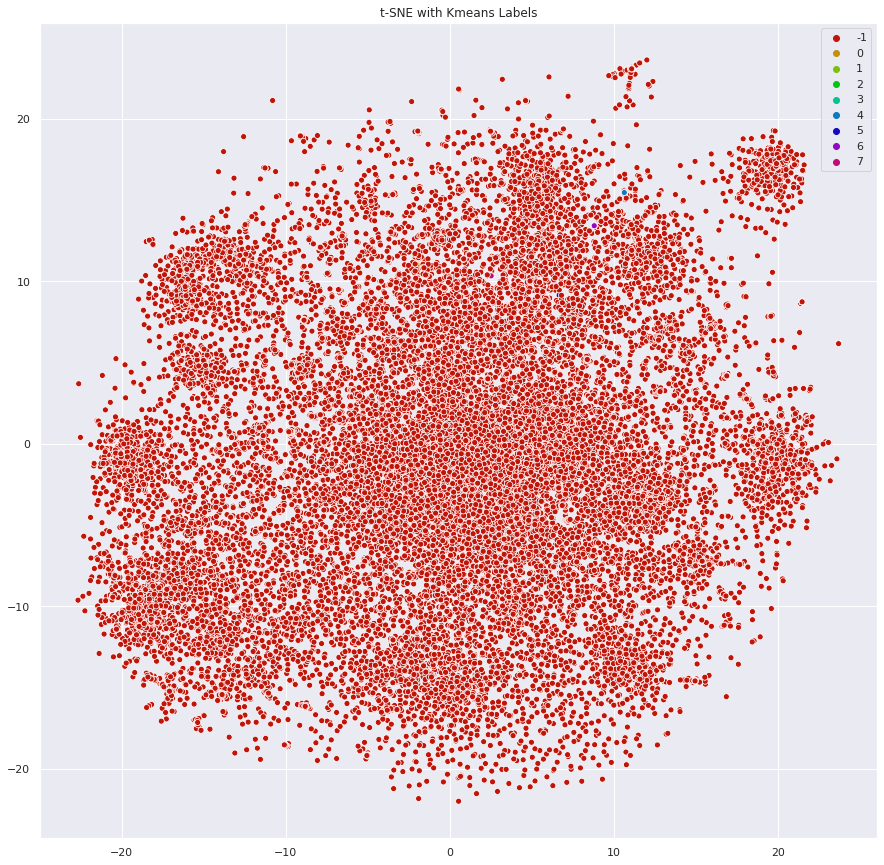

In [ ]:
# sns settings
sn.set(rc={'figure.figsize':(15,15)})

# colors
palette = sn.hls_palette(9, l=.4, s=.9)

# plot
sn.scatterplot(X_embedded[:,0], X_embedded[:,1], hue=y_pred, legend='full', palette=palette)
plt.title('t-SNE with Kmeans Labels')
plt.savefig("improved_cluster_tsne.png")
plt.show()

In [ ]:
Counter(y_pred)

Counter({-1: 24904, 0: 5, 1: 30, 2: 6, 3: 8, 4: 15, 5: 15, 6: 6, 7: 11})

## Gerarchico (la memoria non basta, non funzionante, da non runnare)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tf_idf_matrix)

In [ ]:
from scipy.cluster.hierarchy import ward, dendrogram, fcluster, linkage

In [ ]:
linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

In [ ]:
fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
#plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [ ]:
val = []
for i in tqdm_notebook(range(31, 50)):
    assignments = fcluster(linkage_matrix, i, 'distance')
    val.append(silhouette_score(tf_idf_matrix, assignments))

# WordCloud

In [ ]:
from PIL import Image
from wordcloud import WordCloud, ImageColorGenerator

In [ ]:
corpus_wc = data['text_final'].progress_apply(lambda x: create_sentence(x))

In [ ]:
text = pd.DataFrame(corpus_wc)
text["cluster"] = y_pred

In [ ]:
for i in tqdm_notebook(range(k)):
    wordcloud = WordCloud(max_words=100, background_color="white", stopwords=["time", "great", "like", "love", "make", "go", "well", "get", "good"]).generate(" ".join(text[text["cluster"] == i]["text_final"].values))
    titolo = "Cluster: " + str(i)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(titolo, fontsize=50)
    plt.axis("off")
    plt.show()
    print("\n")